In [53]:
%pip install langchain-text-splitters transformers pandas numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [54]:
import weaviate
import numpy as np
from weaviate.classes.config import Configure, VectorDistances
import weaviate.classes as wvc
from tables import classes, schema_dicts

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import plotly.express as px

In [55]:
display(schema_dicts)
rng = 42
np.random.seed(rng)

[{'name': 'Distilbert',
  'url': 'http://t2v-transformers:8080',
  'schema': 'DSMDistilbert'},
 {'name': 'Roberta',
  'url': 'http://t2v-transformers-drobert:8080',
  'schema': 'DSMRoberta'},
 {'name': 'Biobert',
  'url': 'http://t2v-transformers-biobert:8080',
  'schema': 'DSMBiobert'},
 {'name': 'Clinicalbert',
  'url': 'http://t2v-transformers-clicbert:8080',
  'schema': 'DSMClinicalbert'}]

## Latent Space Visualization 

Fetched 1957 vectors.


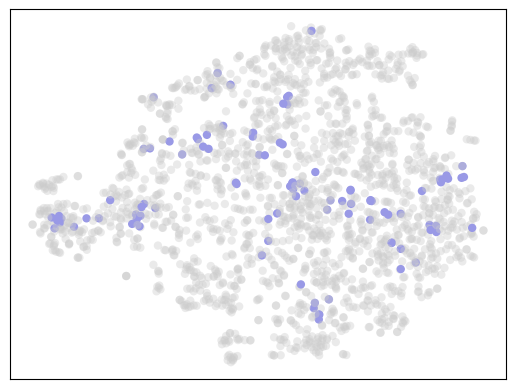

Average pairwise cos distance: 0.088
Average pairwise euc distance: 3.126
Fetched 1957 vectors.


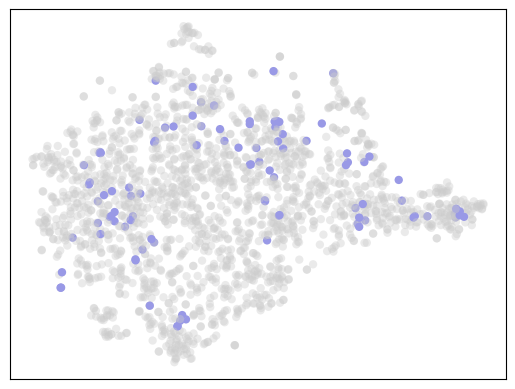

Average pairwise cos distance: 0.009
Average pairwise euc distance: 1.687
Fetched 1957 vectors.


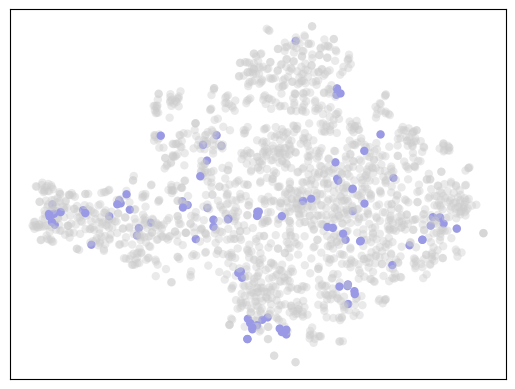

Average pairwise cos distance: 0.042
Average pairwise euc distance: 2.848
Fetched 1957 vectors.


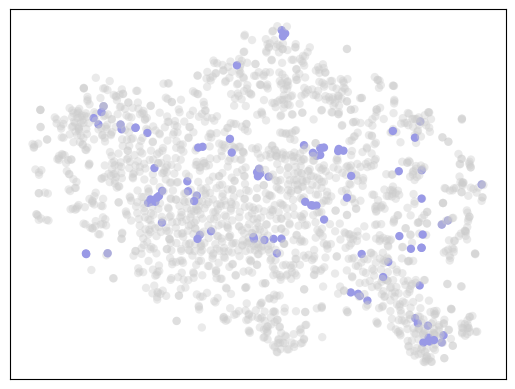

Average pairwise cos distance: 0.104
Average pairwise euc distance: 2.953


In [56]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

for schema_index in range(len(schema_dicts)):
    client = weaviate.connect_to_local()
    try:
        dsm = client.collections.get(schema_dicts[schema_index]["schema"])
        response = dsm.query.fetch_objects(limit=10000, include_vector=True)

        vectors = np.array([np.array(obj.vector["text_vector"]) for obj in response.objects])
        titles = np.array(np.array([obj.properties["title"] for obj in response.objects]))

        print(f"Fetched {len(vectors)} vectors.")
    except Exception as ex:
        print(f"Error: {ex}")
    finally:
        client.close()

    unique_titles = list(set(titles))
    # print(unique_titles)

    # PCA can show relative structure (e.g., tight vs. loose clusters)
    # PCA only works for linear type things so instaed...
    # pca = PCA(n_components=3)
    # reduced_vectors = pca.fit_transform(vectors)

    # We can use TSNE which works much better for manifod type structures
    # metric='cosine',
    tsne = TSNE(n_components=2, random_state=rng)
    reduced_vectors = tsne.fit_transform(vectors)

    # print(len(reduced_vectors))
    # print(len(vectors))
    # print(len(titles))

    # unique_titles = list(set(titles))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_titles)))

    # Define pastel colors with transparency
    color_depression = (0.6, 0.6, 0.9, 1.0)
    color_other      = (0.8, 0.8, 0.8, 0.4)

    # This works because the arrays have the same number of elements and this
    # "fills it out" for each row as it goes - its not like a loop
    kolor = [color_depression if title == "Depressive Disorders" else color_other for title in titles]
    kolor = np.array(kolor)
    # print(kolor)
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=kolor, edgecolors='none')

    # Add legend
    # legend_patches = [
    #     mpatches.Patch(color=color_depression, label='Depressive Disorders'),
    #     mpatches.Patch(color=color_other, label='Other Disorders')
    # ]
    # plt.legend(handles=legend_patches, loc='upper left')

    # plt.title(schema_dicts[schema_index]["name"])
    # plt.xlabel("tSNE 1")
    # plt.ylabel("tSNE 2")
    plt.xticks([])
    plt.yticks([])

    plt.savefig( f'graphs/tsne_plot_{schema_dicts[schema_index]["name"]}.png', dpi=300, bbox_inches='tight')

    plt.show()

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.metrics.pairwise import euclidean_distances
    import numpy as np

    # Assume `vectors` is your numpy array of embeddings
    cos_distance_matrix = cosine_distances(vectors)
    euc_distance_matrix = euclidean_distances(vectors)
    cos_avg_distance = np.mean(cos_distance_matrix)
    euc_avg_distance = np.mean(euc_distance_matrix)
    print(f"Average pairwise cos distance: {cos_avg_distance:.3f}")
    print(f"Average pairwise euc distance: {euc_avg_distance:.3f}")

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    if False:
        fig = px.scatter_3d(
            x=reduced_vectors[:, 0],
            y=reduced_vectors[:, 1],
            z=reduced_vectors[:, 2],
            color=titles,
            title=f'{schema_dicts[schema_index]["name"]} Vectors',
            size_max=3,
            opacity=0.7
        )
        fig.update_traces(marker=dict(size=4))
        fig.update_layout(
            width=1200,   # in pixels
            height=800,   # in pixels
            title_font_size=20,
        )
        fig.update(layout_showlegend=False)
        fig.show()

        fig.write_html(f'graphs/pca_plot_{schema_dicts[schema_index]["name"]}.html')
        fig.write_image(
            f'graphs/pca_plot_{schema_dicts[schema_index]["name"]}.png',
            width=1200,
            height=800,
            scale=1
        )
